In [125]:
#If you wish to install the requirements from this notebook, uncomment this code and run this cell

#!pip install tilemapbase
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install tqdm
#!pip install kaggle

<h1>References</h1>

<a href='https://www.kaggle.com/stoney71/new-york-city-transport-statistics'>Dataset</a>

<a href='https://github.com/MatthewDaws/TileMapBase'>Tilemapbase</a>

<a href='http://astro.unl.edu/naap/motion1/tc_units.html'>Ways to express latitude and longitude</a>

<a href='https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points'>Harversine formula</a>

<a href='https://www.kaggle.com/docs/api#getting-started-installation-&-authentication'>How to create a kaggle API token for downloading the dataset</a>

In [ ]:
import os
import kaggle
import csv
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt

from math import radians, cos, sin, asin, sqrt
from tqdm import tqdm

import tilemapbase

tilemapbase.start_logging()
tilemapbase.init(create=True)
t = tilemapbase.tiles.build_OSM()

In [ ]:
bus_files = ['mta_1706.csv', 'mta_1708.csv', 'mta_1710.csv', 'mta_1712.csv']

In [104]:
def download_datset():
    print('Downloading...')
    present_csv_files = [f for f in os.listdir('.') if '.csv' in f]
    missing_files = [f for f in bus_files if f not in present_csv_files]
    if len(missing_files) > 0:
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files('stoney71/new-york-city-transport-statistics', path='.', unzip=True)
        print('Done downloading!')
    else:
        print('Dataset already downloaded')

download_datset()

Downloading...
Dataset already downloaded


In [122]:
def take_from_line(filename, line_name, line_name_column='PublishedLineName'):
    raw1 = csv.reader(open(filename, 'r'), quotechar='"', delimiter=',',
                     quoting=csv.QUOTE_ALL, skipinitialspace=True)
    columns = raw1.__next__()
    ind = columns.index(line_name_column)
    target_lines = []
    for line in tqdm(raw1):
        if line[ind] == line_name:
            target_lines.append(line)
    return pd.DataFrame(target_lines, columns=columns)

def fetch_unique_of_column(filename, column_name):
    raw1 = csv.reader(open(filename, 'r'), quotechar='"', delimiter=',',
                     quoting=csv.QUOTE_ALL, skipinitialspace=True)
    columns = raw1.__next__()
    ind = columns.index(column_name)
    target_lines = []
    all_values = []
    
    for line in tqdm(raw1):
        all_values.append(line[ind])
    return list(set(all_values))

#From https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_km(lon1, lat1, lon2, lat2):
    lon1 = float(lon1)
    lat1 = float(lat1)
    lon2 = float(lon2)
    lat2 = float(lat2)
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def fetch_sequence(df, column):
    sequence = []
    last_one = None
    period = 0
    calculated_period = False
    
    for key, row in tqdm(df.iterrows()):
        current_value = row[column]
        if last_one is None:
            last_one = current_value
            
            if last_one not in sequence and not calculated_period:
                period += 1
            else:
                calculated_period = True
            
            sequence.append(last_one)
            continue
        
        if current_value != last_one:
            last_one = current_value
            
            if last_one not in sequence and not calculated_period:
                period += 1
            else:
                calculated_period = True
                
            sequence.append(last_one)
    return sequence, period

def fetch_extreme_points(df, bus_stop_column='NextStopPointName', direction_column='DirectionRef'):
    last_direction = None
    extremes_0_1 = []
    extremes_1_0 = []
    
    for key, row in tqdm(df.iterrows()):
        current_direction = row[direction_column]
        current_stop = row[bus_stop_column]
        
        if last_direction is None:
            last_direction = current_direction
            continue
        
        
        if current_direction == '0' and last_direction == '1':
            extremes_1_0.append(current_stop)
        
        if current_direction == '1' and last_direction == '0':
            extremes_0_1.append(current_stop)
        
        last_direction = current_direction
    return extremes_0_1, extremes_1_0


def compute_path_pairs(df, next_stop_column='NextStopPointName'):
    previous_next = df[next_stop_column].shift(1)
    df['previous_next'] = previous_next
    
    different_df = df[~(df[next_stop_column] == previous_next)]
    pairs = {}
    for key, row in different_df.iterrows():
        current_stop = row['previous_next']
        next_stop = row[next_stop_column]
        if current_stop in pairs:
            if next_stop not in pairs[current_stop]:
                pairs[current_stop].append(next_stop)
        else:
            pairs[current_stop] = [next_stop]
            
    df.drop(['previous_next'], axis=1)
    return pairs

def plot_medium_time_offset(df, time_column='RecordedAtTime', direction_column='DirectionRef'):
    previous_directions = df[direction_column].shift(1)
    previous_times = df[time_column].shift(1)
    current_times_filtered = df[(df[direction_column] == previous_directions)][time_column]
    previous_times_filtered = previous_times[(df[direction_column] == previous_directions)]
    current_times_filtered_ts = pd.to_datetime(current_times_filtered)
    previous_times_filtered_ts = pd.to_datetime(previous_times_filtered)
    diffs = (current_times_filtered_ts - previous_times_filtered_ts).apply(lambda x: x.total_seconds()/60)
    max_90 = np.percentile(diffs, 90)
    
    plt.figure()
    plt.title('Time offset between readings')
    plt.xlabel('time offset')
    plt.ylabel('num readings')
    plt.hist(diffs, bins=np.linspace(0, max_90, 100))
    plt.show(block=False)
    
    print('Max offset', diffs.max())
    print('Minimum offset', diffs.min())
    print('Median offset', diffs.median())
    return diffs

def time_to_total_seconds(time_obj):
    return 3600*time_obj.hour + 60*time_obj.minute + time_obj.second

def compute_simpler_date_columns(df, time_column='RecordedAtTime',simplify_term=10*60):
    df_to_use = df.copy()
    
    datetimes = pd.to_datetime(df_to_use[time_column])
    df_to_use['TimeWithinDays'] = datetimes.apply(lambda x: time_to_total_seconds(x.time())//simplify_term)
    df_to_use['Date'] = datetimes.apply(lambda x: x.date())
    
    return df_to_use

def update_multilevel_dictionary(my_dict, keys, value_to_add):
    dict_to_look = my_dict
                                 
    for k in keys[:-1]:
        if k not in dict_to_look:
            dict_to_look[k] = {}
        dict_to_look = dict_to_look[k]
        
    dict_to_look = my_dict
    
    for k in keys[:-1]:
        dict_to_look = dict_to_look[k]
    
    if keys[-1] not in dict_to_look:
        dict_to_look[keys[-1]] = [value_to_add]
    else:
        dict_to_look[keys[-1]].append(value_to_add)
    return my_dict

def compute_average_position_bus_stop(df, next_stop_column='NextStopPointName', lat_column='VehicleLocation.Latitude', long_column='VehicleLocation.Longitude'):
    previous_next = df[next_stop_column].shift(1)
    useful_df = pd.DataFrame([], columns=[next_stop_column, 'PreviousNext', lat_column, long_column])
    useful_df[next_stop_column] = df[next_stop_column]
    useful_df['PreviousNext'] = previous_next
    useful_df[lat_column] = df[lat_column]
    useful_df[long_column] = df[long_column]
    
    useful_df_filtered = useful_df[(~(useful_df['PreviousNext'] == useful_df[next_stop_column]))]
    locations = {}
    
    for key, row in useful_df_filtered.iterrows():
        current_stop = row['PreviousNext']
        if str(current_stop) == 'nan':
            continue
        
        latitude = float(row[lat_column])
        longitude = float(row[long_column])
        
        locations = update_multilevel_dictionary(locations, (current_stop, 'latitude'), latitude)
        locations = update_multilevel_dictionary(locations, (current_stop, 'longitude'), longitude)
        
    for key in locations.keys():
        locations[key]['latitude'] = np.mean(locations[key]['latitude'])
        locations[key]['longitude'] = np.mean(locations[key]['longitude'])
    return locations

def compute_mean_duration_by_pair(df, line_identifier='PublishedLineName', time_column='RecordedAtTime', direction_column='DirectionRef', 
                                  next_stop_column='NextStopPointName', simplify_term=10*60, pairs=None):
    
    current_line = df[line_identifier]
    
    df_new = compute_simpler_date_columns(df, time_column=time_column, simplify_term=simplify_term)
    previous_next = df_new[next_stop_column].shift(1)
    previous_directions = df_new[direction_column].shift(1)
    current_times_ts = pd.to_datetime(df_new[time_column])
    
    useful_df = pd.DataFrame([], columns=[time_column, direction_column, next_stop_column, 'PreviousNext', 
                                          'PreviousDirection', 'TimeWithinDays'])
    useful_df[time_column] = current_times_ts
    useful_df[direction_column] = df_new[direction_column]
    useful_df[next_stop_column] = df_new[next_stop_column]
    useful_df['PreviousNext'] = previous_next
    useful_df['PreviousDirection'] = previous_directions
    useful_df['TimeWithinDays'] = df_new['TimeWithinDays']
    
    useful_df_filtered = useful_df[(~(useful_df['PreviousNext'] == useful_df[next_stop_column])) &
                                  (useful_df['PreviousDirection'] == useful_df[direction_column])]
    
    if pairs is None:
        pairs = {}
    
    previous_key = None
    
    for key, row in useful_df_filtered.iterrows():
        if previous_key is not None:
            previous_row = useful_df_filtered.loc[previous_key,:]
            previous_key = key
        else:
            previous_key = key
            continue
            
        stop_1 = previous_row['PreviousNext']
        stop_2 = previous_row[next_stop_column]
        time_of_day = previous_row['TimeWithinDays']
        
        time_delta = (row[time_column] - previous_row[time_column]).total_seconds()
        
        if str(stop_1) == 'nan':
            continue
            
        pairs = update_multilevel_dictionary(pairs, (line_identifier, stop_1, stop_2, time_of_day), time_delta)
            
    return pairs


def list_of_stops_to_path_list(list_of_stops, stops_location_dict):
    path_list = []
    for L in list_of_stops:
        path_list.append((L, stops_location_dict[L]))
    return path_list

def plot_series_of_stops(list_of_stops, stops_location_dict, min_degree_offset=0.0001):
    path_list = list_of_stops_to_path_list(list_of_stops, stops_location_dict)
    
    coords = [(x[1]['longitude'], x[1]['latitude']) for x in path_list]
    stops_names = [x[0] for x in path_list]
    
    all_x = []
    all_y = []
    
    for c in coords:
        x, y = tilemapbase.project(*c)
        all_x.append(x)
        all_y.append(y)
    
    min_x = min(all_x) - min_degree_offset
    max_x = max(all_x) + min_degree_offset
    min_y = min(all_y) - min_degree_offset
    max_y = max(all_y) + min_degree_offset
    
    extent = tilemapbase.Extent(min_x, max_x, min_y, max_y)
    extent = extent.to_aspect(1.0)
    
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)
    
    ax.scatter(all_x,all_y, marker="o", color="black", s=8)
    for i, txt in enumerate(stops_names):
        ax.annotate(txt + ' (%d)' % i, xy=(all_x[i], all_y[i]), fontsize=7)

def filter_sequence_by_another(seq1, seq2, val_to_filter):
    return [s for i, s in enumerate(seq1) if seq2[i] == val_to_filter]

def plot_series_of_stops_with_bus_path(list_of_stops, stops_location_dict, bus_positions, directions, min_degree_offset=0.0001):
    path_list = list_of_stops_to_path_list(list_of_stops, stops_location_dict)
    
    coords = [(x[1]['longitude'], x[1]['latitude']) for x in path_list]
    stops_names = [x[0] for x in path_list]
    
    all_x = []
    all_y = []
    
    for c in coords:
        x, y = tilemapbase.project(*c)
        all_x.append(x)
        all_y.append(y)
        
    bus_x = []
    bus_y = []
    
    for b in bus_positions:
        x, y = tilemapbase.project(*b)
        bus_x.append(x)
        bus_y.append(y)
    
    directions = list(directions)
    
    bus_x_0 = filter_sequence_by_another(bus_x, directions, '0')
    bus_y_0 = filter_sequence_by_another(bus_y, directions, '0')
    bus_x_1 = filter_sequence_by_another(bus_x, directions, '1')
    bus_y_1 = filter_sequence_by_another(bus_y, directions, '1')
    
    min_x = min(all_x) - min_degree_offset
    max_x = max(all_x) + min_degree_offset
    min_y = min(all_y) - min_degree_offset
    max_y = max(all_y) + min_degree_offset
    
    extent = tilemapbase.Extent(min_x, max_x, min_y, max_y)
    extent = extent.to_aspect(1.0)
    
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, t, width=600)
    plotter.plot(ax, t)
    
    ax.scatter(all_x,all_y, marker="o", color="black")
    
    ax.scatter(bus_x_0, bus_y_0, marker='x')
    ax.scatter(bus_x_1, bus_y_1, marker='*')
    ax.legend(['stops', '0', '1'])
    
    for i, txt in enumerate(stops_names):
        ax.annotate(txt + ' (%d)' % i, xy=(all_x[i], all_y[i]))
        
def plot_dataframe_info(df, stops_location_dict, direction_column='DirectionRef', time_column='RecordedAtTime', next_stop_column='NextStopPointName', lat_column='VehicleLocation.Latitude', long_column='VehicleLocation.Longitude'):
    sorted_df = df.sort_values(by=time_column)
    buses_stops = list(sorted_df[next_stop_column].unique())
    bus_positions = [(float(x[long_column]), 
                      float(x[lat_column])) for key, x in sorted_df.iterrows()]
    directions = sorted_df[direction_column]
    
    plot_series_of_stops_with_bus_path(buses_stops, stops_location_dict, bus_positions, directions, min_degree_offset=0.0001)

In [5]:
line_b8 = take_from_line('mta_1706.csv', 'B8')

6730856it [00:50, 133651.03it/s]


In [6]:
line_b8.head(20)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.63517,-73.960803,FOSTER AV/E 18 ST,approaching,76,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:30,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.628821,-73.980484,18 AV/47 ST,approaching,120,2017-06-01 00:03:56,24:14:50
2,2017-06-01 00:03:32,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_449,40.610358,-73.999045,18 AV/79 ST,approaching,135,2017-06-01 00:04:00,24:04:25
3,2017-06-01 00:03:54,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_417,40.649176,-73.91686,REMSEN AV/AV B,approaching,93,2017-06-01 00:04:15,24:06:19
4,2017-06-01 00:03:29,1,B8,ROCKAWAY AV/HEGEMAN AV,40.655903,-73.907318,BAY RIDGE 95 ST STA,40.616261,-74.031128,NYCT_369,40.655694,-73.907161,LINDEN BL/THOMAS BOYLAND ST,< 1 stop away,329,2017-06-01 00:04:02,23:59:10
5,2017-06-01 00:03:28,1,B8,ROCKAWAY AV/HEGEMAN AV,40.655903,-73.907318,BAY RIDGE 95 ST STA,40.616261,-74.031128,NYCT_390,40.611549,-73.99784,18 AV/79 ST,approaching,95,2017-06-01 00:03:56,23:59:54
6,2017-06-01 00:03:34,1,B8,ROCKAWAY AV/HEGEMAN AV,40.655903,-73.907318,BAY RIDGE 95 ST STA,40.616261,-74.031128,NYCT_359,40.616314,-74.030989,4 AV/95 ST,at stop,8,2017-06-01 00:03:56,23:58:00
7,2017-06-01 00:03:34,1,B8,ROCKAWAY AV/HEGEMAN AV,40.655903,-73.907318,V A HOSP,40.608406,-74.023376,NYCT_479,40.63395,-73.970384,18 AV/OCEAN PY,approaching,137,2017-06-01 00:04:00,24:04:29
8,2017-06-01 00:13:39,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.641242,-73.943749,AV D/E 35 ST,approaching,35,2017-06-01 00:13:57,24:15:06
9,2017-06-01 00:13:42,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.63568,-73.959745,FOSTER AV/OCEAN AV,< 1 stop away,172,2017-06-01 00:14:31,24:07:15


In [7]:
b8_buses = line_b8['VehicleRef'].unique()

In [106]:
b8_buses[:10]

array(['NYCT_430', 'NYCT_399', 'NYCT_449', 'NYCT_417', 'NYCT_369',
       'NYCT_390', 'NYCT_359', 'NYCT_479', 'NYCT_357', 'NYCT_428'],
      dtype=object)

In [107]:
one_bus = line_b8[line_b8['VehicleRef'] == 'NYCT_399']

In [108]:
one_bus = one_bus.sort_values(by='RecordedAtTime')

In [109]:
one_bus.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
1,2017-06-01 00:03:30,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.628821,-73.980484,18 AV/47 ST,approaching,120,2017-06-01 00:03:56,24:14:50
9,2017-06-01 00:13:42,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.63568,-73.959745,FOSTER AV/OCEAN AV,< 1 stop away,172,2017-06-01 00:14:31,24:07:15
17,2017-06-01 00:23:52,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.641498,-73.939632,AV D/E 39 ST,at stop,10,2017-06-01 00:23:57,24:16:36
33,2017-06-01 00:53:14,0,B8,CROPSEY AV/VETERANS HOSPITAL,40.608234,-74.022408,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.655955,-73.91285,HEGEMAN AV/THOMAS S BOYLAND ST,< 1 stop away,308,NA,24:41:19
34,2017-06-01 00:53:14,0,B8,CROPSEY AV/VETERANS HOSPITAL,40.608234,-74.022408,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_399,40.655955,-73.91285,HEGEMAN AV/THOMAS S BOYLAND ST,< 1 stop away,308,NA,24:36:19


In [110]:
stops_locations = compute_average_position_bus_stop(one_bus)

In [111]:
stops_locations

{'18 AV/47 ST': {'latitude': 40.62635925, 'longitude': -73.97744525},
 'FOSTER AV/OCEAN AV': {'latitude': 40.63774875, 'longitude': -73.95669325},
 'AV D/E 39 ST': {'latitude': 40.651284000000004, 'longitude': -73.918724},
 'HEGEMAN AV/THOMAS S BOYLAND ST': {'latitude': 40.654939666666664,
  'longitude': -73.91427766666666},
 'CHURCH AV/E 93 ST': {'latitude': 40.64663588888889,
  'longitude': -73.92438633333333},
 'AV D/E 46 ST': {'latitude': 40.637484, 'longitude': -73.955986},
 'FOSTER AV/E 22 ST': {'latitude': 40.634436799999996,
  'longitude': -73.963636},
 '18 AV/58 ST': {'latitude': 40.60948833333333, 'longitude': -74.001739},
 'CROPSEY AV/16 AV': {'latitude': 40.615247249999996,
  'longitude': -74.02283824999999},
 '4 AV/95 ST': {'latitude': 40.613662090909095,
  'longitude': -74.02772781818182},
 'FT HAMILTON PKWY/MARINE AV': {'latitude': 40.607922333333335,
  'longitude': -74.010654},
 'CROPSEY AV/17 AV': {'latitude': 40.616807333333334, 'longitude': -73.992528},
 '18 AV/60 ST

The gps readings are made, in average, each 10 minutes

<IPython.core.display.Javascript object>


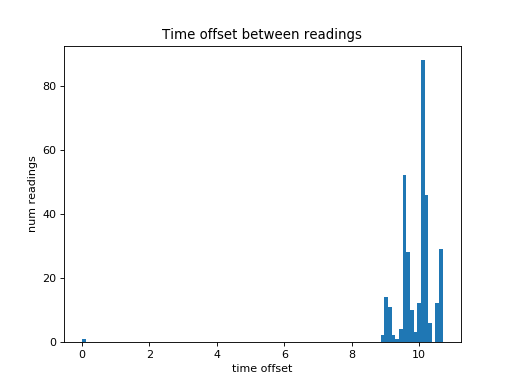

Max offset 12004.366666666667
Minimum offset 0.0
Median offset 10.1


In [112]:
%matplotlib notebook
diffs = plot_medium_time_offset(one_bus, 'RecordedAtTime', 'DirectionRef')

Tried to find the buses stops in which the direction flag changes (might be the extremes of the bus path)

In [117]:
extremes_0_1, extremes_1_0 = fetch_extreme_points(one_bus, 'NextStopPointName', 'DirectionRef')

396it [00:00, 10160.30it/s]


There are lots of different extremes (odd)

In [118]:
extremes_1_0

['FT HAMILTON PKWY/MARINE AV',
 'FT HAMILTON PKY/95 ST',
 'POLY PL/7 AV',
 '4 AV/97 ST',
 '4 AV/97 ST',
 '7 AV/92 ST',
 '92 ST/FT HAMILTON PY',
 'FT HAMILTON PKWY/MARINE AV',
 'POLY PL/7 AV',
 '18 AV/BAY RIDGE PY',
 '92 ST/FT HAMILTON PY',
 'FT HAMILTON PKWY/MARINE AV',
 'FT HAMILTON PKY/95 ST',
 '92 ST/FT HAMILTON PY',
 'CROPSEY AV/BAY 7 ST',
 '7 AV/POLY PREP ENT',
 'CROPSEY AV/17 AV',
 'CROPSEY AV/15 AV',
 'POLY PL/7 AV']

In [119]:
bus_stops_sequence, period = fetch_sequence(one_bus, 'NextStopPointName')

396it [00:00, 10421.09it/s]


In [120]:
period

15

The bus stop sequence seems irregular

In [116]:
print(bus_stop_sequence[:period])
print('-----')
print('Next', bus_stop_sequence[period])

['18 AV/47 ST', 'FOSTER AV/OCEAN AV', 'AV D/E 39 ST', 'HEGEMAN AV/THOMAS S BOYLAND ST', 'CHURCH AV/E 93 ST', 'AV D/E 46 ST', 'FOSTER AV/E 22 ST', '18 AV/58 ST', 'CROPSEY AV/16 AV', '4 AV/95 ST', 'FT HAMILTON PKWY/MARINE AV', 'CROPSEY AV/17 AV', '18 AV/60 ST', 'FOSTER AV/E 18 ST', 'AV D/E 45 ST']
-----
Next CHURCH AV/E 93 ST


The sequence didn't go back to the first

These are the bus stops for the bus under analysis

<IPython.core.display.Javascript object>


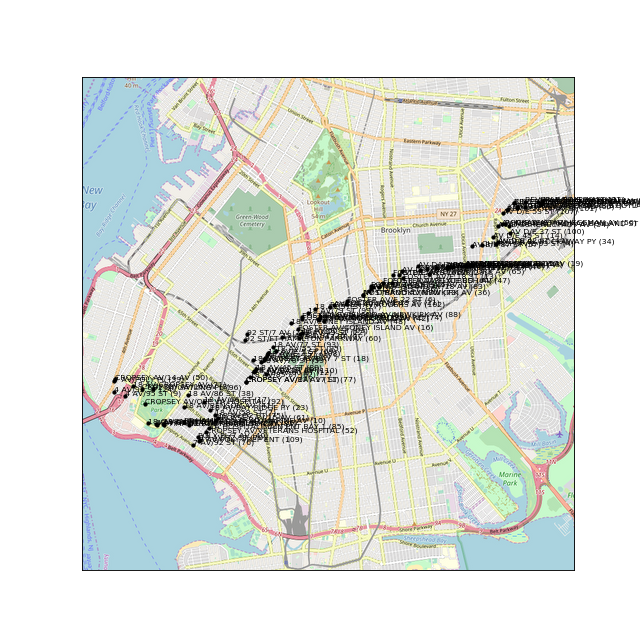

In [123]:
%matplotlib notebook

plot_series_of_stops(list(stops_locations.keys()), stops_locations)

<IPython.core.display.Javascript object>


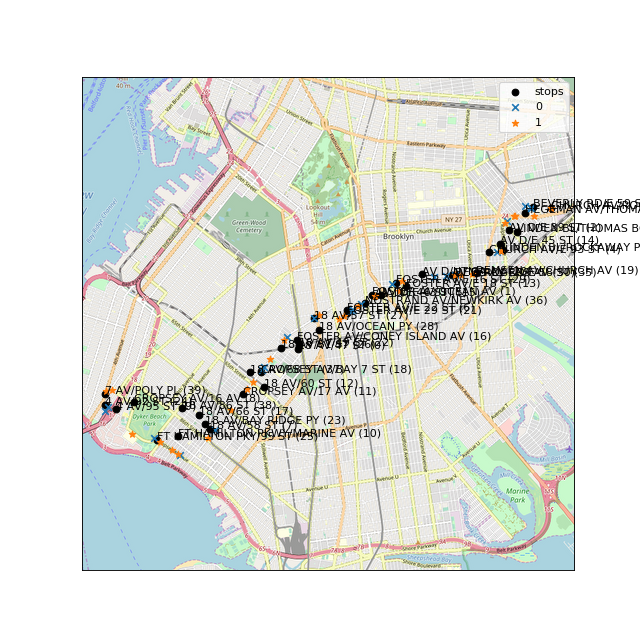

In [124]:
plot_dataframe_info(one_bus.head(50), stops_locations)